<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_P6_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [1]:
!pip install feature_engine

     |████████████████████████████████| 9.5MB 7.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install plotly

In [3]:
!pip install chart-studio

     |████████████████████████████████| 71kB 3.5MB/s 


In [4]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
from collections import Counter
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
#df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
#df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
#frames = [df_analysis_01, df_analysis_02, df_analysis_03]
#df_analysis = pd.concat(frames)
#df_sample = df_analysis.sample(n=40000)
#df_sample.to_csv('df_sample.csv')

In [13]:
df_sample = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/df_sample.csv')
df_sample = df_sample.drop(['Unnamed: 0'], axis=1)
df_sample.head()

,Id,Body,Title,Tags,CreationDate
0,60535993,<p>How were Unity developers able to constrain...,How were Unity developers able to constrain a ...,<c#><unity3d><generics><constraints>,2020-03-04 23:04:31
1,58385540,"<p>I believe the answer to this is ""no"", but i...",Get Angular component class from DOM element,<angular>,2019-10-15 00:13:57
2,48096487,<p>I have 2 parts to my question. If I have a ...,SharePoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...,2018-01-04 13:34:21
3,56184687,<p>I am working on a platfor that hosts small ...,"""In a distributed environment, one does not us...",<java><multithreading><concurrency><distribute...,2019-05-17 10:36:47
4,50153805,<p>I have been trying to trigger the browser a...,"Karma test runner error: ""An error was thrown ...",<node.js><karma-runner><karma-jasmine><browser...,2018-05-03 11:19:57


In [14]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            40000 non-null  int64 
 1   Body          40000 non-null  object
 2   Title         40000 non-null  object
 3   Tags          40000 non-null  object
 4   CreationDate  40000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [15]:
df_sample = df_sample.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_sample = df_sample.set_index('Id').reset_index(drop=True)
df_sample.head()

,Title,Body,Tags
0,How were Unity developers able to constrain a ...,<p>How were Unity developers able to constrain...,<c#><unity3d><generics><constraints>
1,Get Angular component class from DOM element,"<p>I believe the answer to this is ""no"", but i...",<angular>
2,SharePoint security inheritance underlying imp...,<p>I have 2 parts to my question. If I have a ...,<sharepoint><sharepoint-online><sharepoint-sec...
3,"""In a distributed environment, one does not us...",<p>I am working on a platfor that hosts small ...,<java><multithreading><concurrency><distribute...
4,"Karma test runner error: ""An error was thrown ...",<p>I have been trying to trigger the browser a...,<node.js><karma-runner><karma-jasmine><browser...


## **3.Preprocessing**

In [16]:
df_sample.duplicated(subset=["Body", "Title"]).sum()

0

In [17]:
example_body = df_sample.Body.iloc[0]

In [18]:
example_body

'<p>How were Unity developers able to constrain a generic type parameter on being derived from Object?</p>\n\n<p>While looking for an answer to the question I come over <a href="https://stackoverflow.com/questions/10644703/c-sharp-generics-constraining-t-where-t-object-doesnt-compile-error-constr">the question</a>. There is the answer which tells the following:</p>\n\n<blockquote>\n  <p>There is no difference between the two constraints, except for that one is disallowed for being useless to explicitly state.</p>\n</blockquote>\n\n<p>Proving that it should be impossible to constrain on Object. While in Unity we can see the following method:</p>\n\n<pre><code>public static T Instantiate&lt;T&gt;(T original, Vector3 position, Quaternion rotation) where T : Object;\n</code></pre>\n\n<p><a href="https://i.stack.imgur.com/0WCHz.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/0WCHz.png" alt="enter image description here"></a></p>\n\n<p>Does it happen because Unity is using

In [19]:
example_title = df_sample.Title.iloc[0]

In [20]:
example_title

'How were Unity developers able to constrain a generic type parameter on being derived from Object?'

In [21]:
#Merge Title and Body
df_sample['Title_Body'] = df_sample['Title'] + ' ' + df_sample['Body']

In [22]:
df_sample.head()


,Title,Body,Tags,Title_Body
0,How were Unity developers able to constrain a ...,<p>How were Unity developers able to constrain...,<c#><unity3d><generics><constraints>,How were Unity developers able to constrain a ...
1,Get Angular component class from DOM element,"<p>I believe the answer to this is ""no"", but i...",<angular>,Get Angular component class from DOM element <...
2,SharePoint security inheritance underlying imp...,<p>I have 2 parts to my question. If I have a ...,<sharepoint><sharepoint-online><sharepoint-sec...,SharePoint security inheritance underlying imp...
3,"""In a distributed environment, one does not us...",<p>I am working on a platfor that hosts small ...,<java><multithreading><concurrency><distribute...,"""In a distributed environment, one does not us..."
4,"Karma test runner error: ""An error was thrown ...",<p>I have been trying to trigger the browser a...,<node.js><karma-runner><karma-jasmine><browser...,"Karma test runner error: ""An error was thrown ..."


In [23]:
variables_reorganization = ['Title_Body', 'Tags']
df_sample = df_sample[['Title_Body', 'Tags']]

In [24]:
df_sample.head()

,Title_Body,Tags
0,How were Unity developers able to constrain a ...,<c#><unity3d><generics><constraints>
1,Get Angular component class from DOM element <...,<angular>
2,SharePoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...
3,"""In a distributed environment, one does not us...",<java><multithreading><concurrency><distribute...
4,"Karma test runner error: ""An error was thrown ...",<node.js><karma-runner><karma-jasmine><browser...


In [25]:
df_sample.Title_Body.iloc[0]

'How were Unity developers able to constrain a generic type parameter on being derived from Object? <p>How were Unity developers able to constrain a generic type parameter on being derived from Object?</p>\n\n<p>While looking for an answer to the question I come over <a href="https://stackoverflow.com/questions/10644703/c-sharp-generics-constraining-t-where-t-object-doesnt-compile-error-constr">the question</a>. There is the answer which tells the following:</p>\n\n<blockquote>\n  <p>There is no difference between the two constraints, except for that one is disallowed for being useless to explicitly state.</p>\n</blockquote>\n\n<p>Proving that it should be impossible to constrain on Object. While in Unity we can see the following method:</p>\n\n<pre><code>public static T Instantiate&lt;T&gt;(T original, Vector3 position, Quaternion rotation) where T : Object;\n</code></pre>\n\n<p><a href="https://i.stack.imgur.com/0WCHz.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com

### **HTML**

In [26]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [27]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_html)
df_sample.head()

,Title_Body,Tags
0,How were Unity developers able to constrain a ...,<c#><unity3d><generics><constraints>
1,Get Angular component class from DOM element ...,<angular>
2,SharePoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...
3,"""In a distributed environment, one does not us...",<java><multithreading><concurrency><distribute...
4,"Karma test runner error: ""An error was thrown ...",<node.js><karma-runner><karma-jasmine><browser...


In [28]:
df_sample.Title_Body.iloc[0]

'How were Unity developers able to constrain a generic type parameter on being derived from Object?  How were Unity developers able to constrain a generic type parameter on being derived from Object? \n\n While looking for an answer to the question I come over  the question . There is the answer which tells the following: \n\n \n   There is no difference between the two constraints, except for that one is disallowed for being useless to explicitly state. \n \n\n Proving that it should be impossible to constrain on Object. While in Unity we can see the following method: \n\n  public static T Instantiate&lt;T&gt;(T original, Vector3 position, Quaternion rotation) where T : Object;\n  \n\n     \n\n Does it happen because Unity is using Mono, but not CLR? \n'

### **URL**

In [29]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [30]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_url)
df_sample.head()

,Title_Body,Tags
0,How were Unity developers able to constrain a ...,<c#><unity3d><generics><constraints>
1,Get Angular component class from DOM element ...,<angular>
2,SharePoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...
3,"""In a distributed environment, one does not us...",<java><multithreading><concurrency><distribute...
4,"Karma test runner error: ""An error was thrown ...",<node.js><karma-runner><karma-jasmine><browser...


In [31]:
df_sample.Title_Body.iloc[0]

'How were Unity developers able to constrain a generic type parameter on being derived from Object?  How were Unity developers able to constrain a generic type parameter on being derived from Object? \n\n While looking for an answer to the question I come over  the question . There is the answer which tells the following: \n\n \n   There is no difference between the two constraints, except for that one is disallowed for being useless to explicitly state. \n \n\n Proving that it should be impossible to constrain on Object. While in Unity we can see the following method: \n\n  public static T Instantiate&lt;T&gt;(T original, Vector3 position, Quaternion rotation) where T : Object;\n  \n\n     \n\n Does it happen because Unity is using Mono, but not CLR? \n'

### **Punctuation**

In [32]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [33]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_punc)

In [34]:
df_sample.Title_Body.iloc[0]

' How were Unity developers able to constrain a generic type parameter on being derived from Object   How were Unity developers able to constrain a generic type parameter on being derived from Object  \n\n While looking for an answer to the question I come over  the question   There is the answer which tells the following  \n\n \n   There is no difference between the two constraints  except for that one is disallowed for being useless to explicitly state  \n \n\n Proving that it should be impossible to constrain on Object  While in Unity we can see the following method  \n\n  public static T Instantiate lt T gt  T original  Vector3 position  Quaternion rotation  where T   Object \n  \n\n     \n\n Does it happen because Unity is using Mono  but not CLR   \n '

### **Other characters**

In [35]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [36]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_other)
df_sample.head()

,Title_Body,Tags
0,how were unity developers able to constrain a...,<c#><unity3d><generics><constraints>
1,get angular component class from dom element ...,<angular>
2,sharepoint security inheritance underlying im...,<sharepoint><sharepoint-online><sharepoint-sec...
3,in a distributed environment one does not us...,<java><multithreading><concurrency><distribute...
4,karma test runner error an error was thrown...,<node.js><karma-runner><karma-jasmine><browser...


In [37]:
df_sample.Title_Body.iloc[0]

' how were unity developers able to constrain a generic type parameter on being derived from object   how were unity developers able to constrain a generic type parameter on being derived from object     while looking for an answer to the question i come over  the question   there is the answer which tells the following         there is no difference between the two constraints  except for that one is disallowed for being useless to explicitly state       proving that it should be impossible to constrain on object  while in unity we can see the following method      public static t instantiate lt t gt  t original  vector3 position  quaternion rotation  where t   object              does it happen because unity is using mono  but not clr     '

### **Space**

In [38]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [39]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_space)

In [40]:
df_sample.Title_Body.iloc[0]

'how were unity developers able to constrain a generic type parameter on being derived from object how were unity developers able to constrain a generic type parameter on being derived from object while looking for an answer to the question i come over the question there is the answer which tells the following there is no difference between the two constraints except for that one is disallowed for being useless to explicitly state proving that it should be impossible to constrain on object while in unity we can see the following method public static t instantiate lt t gt t original vector3 position quaternion rotation where t object does it happen because unity is using mono but not clr'

In [41]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [42]:
df_sample.head()

,Title_Body,Tags
0,how were unity developers able to constrain a ...,<c#><unity3d><generics><constraints>
1,get angular component class from dom element i...,<angular>
2,sharepoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...
3,in a distributed environment one does not use ...,<java><multithreading><concurrency><distribute...
4,karma test runner error an error was thrown in...,<node.js><karma-runner><karma-jasmine><browser...


### **StopWords**

In [43]:
#Tokenization
#nltk.download("punkt")
#from nltk.tokenize import word_tokenize

In [44]:
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import EnglishStemmer
lemma = WordNetLemmatizer().lemmatize
ps = PorterStemmer()
stemmer = EnglishStemmer()

In [45]:
def remove_stopwords(text):
    text = str(text)
    text = " ".join(word for word in text.split() if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words)
    return text

In [46]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_stopwords)

In [47]:
df_sample.Title_Body.iloc[0]

'unity developers able constrain generic type parameter derived object unity developers able constrain generic type parameter derived object looking answer question come question answer tells following difference constraints disallowed useless explicitly state proving impossible constrain object unity following method public static instantiate lt gt original vector3 position quaternion rotation object happen unity mono clr'

In [48]:
df_sample.head()

,Title_Body,Tags
0,unity developers able constrain generic type p...,<c#><unity3d><generics><constraints>
1,angular component class dom element believe an...,<angular>
2,sharepoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...
3,distributed environment use multithreding work...,<java><multithreading><concurrency><distribute...
4,karma test runner error error thrown afterall ...,<node.js><karma-runner><karma-jasmine><browser...


## **Tokenization**

### **Question**

In [49]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [52]:
def tokenize(document):
  tokens = [lemma(w) for w in document.split() if w.isalpha()]
  return tokens

In [53]:
df_sample['Title_Body_Tokens'] = df_sample['Title_Body'].apply(tokenize)

In [54]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,unity developers able constrain generic type p...,<c#><unity3d><generics><constraints>,"[unity, developer, able, constrain, generic, t..."
1,angular component class dom element believe an...,<angular>,"[angular, component, class, dom, element, beli..."
2,sharepoint security inheritance underlying imp...,<sharepoint><sharepoint-online><sharepoint-sec...,"[sharepoint, security, inheritance, underlying..."
3,distributed environment use multithreding work...,<java><multithreading><concurrency><distribute...,"[distributed, environment, use, multithreding,..."
4,karma test runner error error thrown afterall ...,<node.js><karma-runner><karma-jasmine><browser...,"[karma, test, runner, error, error, thrown, af..."


## **Tags**

In [55]:
from ast import literal_eval

In [56]:
df_sample.Tags.iloc[0]

'<c#><unity3d><generics><constraints>'

In [57]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_sample['Tags'] = df_sample['Tags'].str.replace(key, value)

In [58]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,unity developers able constrain generic type p...,"['c#','unity3d','generics','constraints']","[unity, developer, able, constrain, generic, t..."
1,angular component class dom element believe an...,['angular'],"[angular, component, class, dom, element, beli..."
2,sharepoint security inheritance underlying imp...,"['sharepoint','sharepoint-online','sharepoint-...","[sharepoint, security, inheritance, underlying..."
3,distributed environment use multithreding work...,"['java','multithreading','concurrency','distri...","[distributed, environment, use, multithreding,..."
4,karma test runner error error thrown afterall ...,"['node.js','karma-runner','karma-jasmine','bro...","[karma, test, runner, error, error, thrown, af..."


In [59]:
def to_list(df,column):
  df[column] = df[column].apply(literal_eval)
  return df

In [60]:
df_sample = to_list(df_sample, 'Tags')

In [61]:
reorganization = ['Title_Body', 'Title_Body_Tokens', 'Tags']
df_sample = df_sample[reorganization]
df_sample.head()


,Title_Body,Title_Body_Tokens,Tags
0,unity developers able constrain generic type p...,"[unity, developer, able, constrain, generic, t...","[c#, unity3d, generics, constraints]"
1,angular component class dom element believe an...,"[angular, component, class, dom, element, beli...",[angular]
2,sharepoint security inheritance underlying imp...,"[sharepoint, security, inheritance, underlying...","[sharepoint, sharepoint-online, sharepoint-sec..."
3,distributed environment use multithreding work...,"[distributed, environment, use, multithreding,...","[java, multithreading, concurrency, distribute..."
4,karma test runner error error thrown afterall ...,"[karma, test, runner, error, error, thrown, af...","[node.js, karma-runner, karma-jasmine, browser..."


In [62]:
tags0 = df_sample['Tags']
question0 = df_sample['Title_Body_Tokens']

In [63]:
tag_count = nltk.Counter()
for bloc in tags0:
  tag_count.update([word for word in bloc])
print(len(tag_count))
tag_count.most_common(300)

12693


[('python', 5465),
 ('javascript', 4001),
 ('java', 2828),
 ('android', 2477),
 ('c#', 2076),
 ('c++', 1918),
 ('reactjs', 1604),
 ('angular', 1448),
 ('r', 1341),
 ('python-3.x', 1230),
 ('ios', 1159),
 ('html', 1127),
 ('pandas', 1123),
 ('node.js', 1103),
 ('swift', 991),
 ('typescript', 976),
 ('css', 958),
 ('php', 906),
 ('flutter', 808),
 ('docker', 686),
 ('react-native', 653),
 ('firebase', 608),
 ('c', 582),
 ('spring-boot', 573),
 ('arrays', 562),
 ('amazon-web-services', 551),
 ('tensorflow', 522),
 ('kotlin', 518),
 ('asp.net-core', 484),
 ('dart', 483),
 ('vue.js', 472),
 ('spring', 464),
 ('numpy', 454),
 ('sql', 453),
 ('django', 450),
 ('dataframe', 444),
 ('jquery', 428),
 ('laravel', 415),
 ('regex', 389),
 ('json', 384),
 ('sql-server', 380),
 ('.net', 355),
 ('git', 352),
 ('xcode', 347),
 ('kubernetes', 346),
 ('mysql', 342),
 ('keras', 336),
 ('.net-core', 325),
 ('visual-studio-code', 325),
 ('haskell', 324),
 ('scala', 305),
 ('azure', 296),
 ('webpack', 284),


In [64]:
most_common_tags = [i for i, j in tag_count.items() if j > 100]
len(most_common_tags)

155

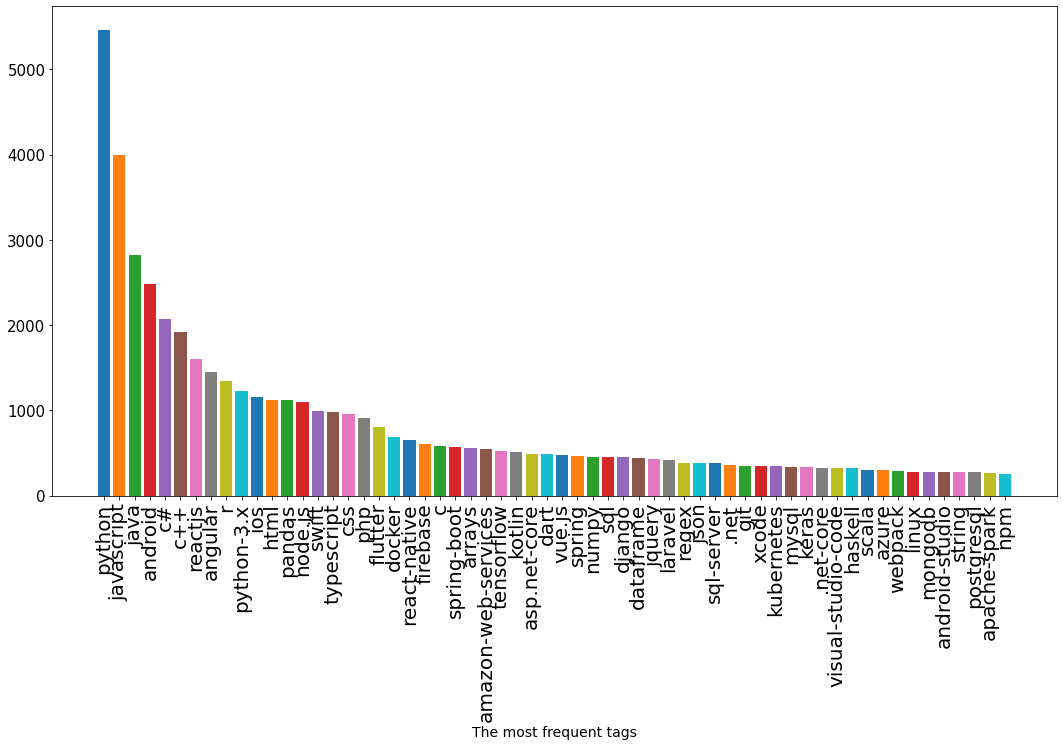

In [65]:
fig, ax = plt.subplots(figsize=(18, 9))


ax.set_xlabel('The most frequent tags', fontsize=14)
ax.bar(x=np.arange(60), 
       height=[x[1] for x in tag_count.most_common(60)],
       tick_label=[x[0] for x in tag_count.most_common(60)],
       color=plt.cm.get_cmap('tab10').colors)

plt.yticks(size=15)
plt.xticks(rotation='vertical', size=20)
plt.show()

In [66]:
def ListeToString(s):
  str1 = " "
  return (str1.join(s))

In [67]:
df_sample['Tag_st'] = df_sample['Tags'].apply(ListeToString)


In [68]:
df_sample.head()

,Title_Body,Title_Body_Tokens,Tags,Tag_st
0,unity developers able constrain generic type p...,"[unity, developer, able, constrain, generic, t...","[c#, unity3d, generics, constraints]",c# unity3d generics constraints
1,angular component class dom element believe an...,"[angular, component, class, dom, element, beli...",[angular],angular
2,sharepoint security inheritance underlying imp...,"[sharepoint, security, inheritance, underlying...","[sharepoint, sharepoint-online, sharepoint-sec...",sharepoint sharepoint-online sharepoint-security
3,distributed environment use multithreding work...,"[distributed, environment, use, multithreding,...","[java, multithreading, concurrency, distribute...",java multithreading concurrency distributed-co...
4,karma test runner error error thrown afterall ...,"[karma, test, runner, error, error, thrown, af...","[node.js, karma-runner, karma-jasmine, browser...",node.js karma-runner karma-jasmine browserify


In [69]:
df_sample = df_sample[['Title_Body', 'Tag_st', 'Title_Body_Tokens', 'Tags']]
df_sample.head()

,Title_Body,Tag_st,Title_Body_Tokens,Tags
0,unity developers able constrain generic type p...,c# unity3d generics constraints,"[unity, developer, able, constrain, generic, t...","[c#, unity3d, generics, constraints]"
1,angular component class dom element believe an...,angular,"[angular, component, class, dom, element, beli...",[angular]
2,sharepoint security inheritance underlying imp...,sharepoint sharepoint-online sharepoint-security,"[sharepoint, security, inheritance, underlying...","[sharepoint, sharepoint-online, sharepoint-sec..."
3,distributed environment use multithreding work...,java multithreading concurrency distributed-co...,"[distributed, environment, use, multithreding,...","[java, multithreading, concurrency, distribute..."
4,karma test runner error error thrown afterall ...,node.js karma-runner karma-jasmine browserify,"[karma, test, runner, error, error, thrown, af...","[node.js, karma-runner, karma-jasmine, browser..."


In [70]:
tags1 = df_sample['Tag_st']
questions1  = df_sample['Title_Body']

In [71]:
tags1.head()

0                      c# unity3d generics constraints
1                                              angular
2     sharepoint sharepoint-online sharepoint-security
3    java multithreading concurrency distributed-co...
4        node.js karma-runner karma-jasmine browserify
Name: Tag_st, dtype: object

In [72]:
questions1.head()

0    unity developers able constrain generic type p...
1    angular component class dom element believe an...
2    sharepoint security inheritance underlying imp...
3    distributed environment use multithreding work...
4    karma test runner error error thrown afterall ...
Name: Title_Body, dtype: object

## **TF-IDF**

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
#X_train, X_test, y_train, y_test = train_test_split(questions1, tags1, test_size=0.2)

In [95]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = stop_words, max_features=2000)
X_tfidf = vectorizer.fit_transform(questions1).toarray()
#X_train_tfidf = vectorizer.fit_transform(X_train).toarray() 
#X_test_tfidf = vectorizer.fit_transform(X_test).toarray()
#print('Total words: ', len(vectorizer.vocabulary))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [82]:
print(X_tfidf.shape)

(40000, 2000)


In [83]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'ab', 'abc', 'able', 'absolute', 'abstract', 'acc', 'accept', 'access', 'accessing', 'according', 'account', 'accuracy', 'achieve', 'action', 'activation', 'active', 'activity', 'activitythread', 'actual', 'actually', 'ad', 'adapter', 'add', 'added', 'addeventlistener', 'adding', 'addition', 'additional', 'address', 'admin', 'advance', 'advice', 'aes', 'age', 'agent', 'aggregate', 'ago', 'airflow', 'ajax', 'alert', 'algorithm', 'alias', 'align', 'alignment', 'allow', 'allowed', 'allows', 'alpha', 'alt', 'alternative', 'amp', 'anaconda', 'analysis', 'analytics', 'android', 'androidx', 'angle', 'angular', 'animation', 'annotation', 'anonymous', 'answer', 'anybody', 'anymore', 'apache', 'api', 'apis', 'apk', 'app', 'appbar', 'appcompat', 'appdata', 'appear', 'appears', 'append', 'apple', 'application', 'applied', 'apply', 'appreciate', 'appreciated', 'approach', 'appropriate', 'apps', 'apt', 'arch', 'architecture', 'archive', 'area', 'arg', 'args', 'argument', 'argv', 'aria'

In [84]:
vectorizer.vocabulary_.items()

dict_items([('unity', 1868), ('developer', 476), ('able', 4), ('generic', 734), ('type', 1845), ('parameter', 1241), ('derived', 463), ('object', 1184), ('looking', 1031), ('answer', 63), ('question', 1400), ('come', 308), ('tell', 1760), ('following', 695), ('difference', 485), ('constraint', 352), ('explicitly', 624), ('state', 1680), ('method', 1093), ('public', 1384), ('static', 1682), ('lt', 1040), ('gt', 773), ('original', 1223), ('position', 1315), ('rotation', 1513), ('happen', 786), ('angular', 59), ('component', 327), ('class', 275), ('dom', 519), ('element', 558), ('believe', 161), ('service', 1591), ('pas', 1253), ('root', 1511), ('node', 1164), ('e', 544), ('g', 719), ('foo', 698), ('receive', 1427), ('instance', 885), ('associated', 114), ('post', 1317), ('example', 600), ('id', 828), ('const', 349), ('document', 515), ('getelementbyid', 737), ('like', 993), ('edit', 550), ('use', 1882), ('global', 748), ('suppose', 1732), ('trying', 1839), ('constructor', 354), ('special

### **TF-IDF Weights**

In [85]:
#get word frequencies and create wordcloud
#tfidf_weights = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [86]:
#type(tfidf_weights)

list

In [87]:
#tfidf_weights[0:10]

[('unity', 38.683387220600736),
 ('developer', 77.25509924640534),
 ('able', 210.68127845415046),
 ('generic', 76.31964414304478),
 ('type', 670.6005111535171),
 ('parameter', 214.33364717516667),
 ('derived', 29.885360887634164),
 ('object', 496.8712726566308),
 ('looking', 138.74090941058185),
 ('answer', 164.96026302839863)]

In [88]:
 #import pickle

#with open("list_tfidf_weights.txt", "wb") as fp:  #Pickling
  #pickle.dump(tfidf_weights , fp)

In [91]:
#with open("list_tfidf_weights.txt", "rb") as fp: # Unpickling
  #list_tfidf_weights = pickle.load(fp)
list_tfidf_weights = pd.read_pickle("/content/drive/My Drive/CentraleSupelec_OCR/P6/list_tfidf_weights.txt")
list_tfidf_weights[0:10]

[('unity', 38.683387220600736),
 ('developer', 77.25509924640534),
 ('able', 210.68127845415046),
 ('generic', 76.31964414304478),
 ('type', 670.6005111535171),
 ('parameter', 214.33364717516667),
 ('derived', 29.885360887634164),
 ('object', 496.8712726566308),
 ('looking', 138.74090941058185),
 ('answer', 164.96026302839863)]

### **WordCloud**

In [92]:
from wordcloud import WordCloud
w = WordCloud(width=1500,height=1200,mode='RGBA',background_color='white',max_words=2000).fit_words(dict(list_tfidf_weights))

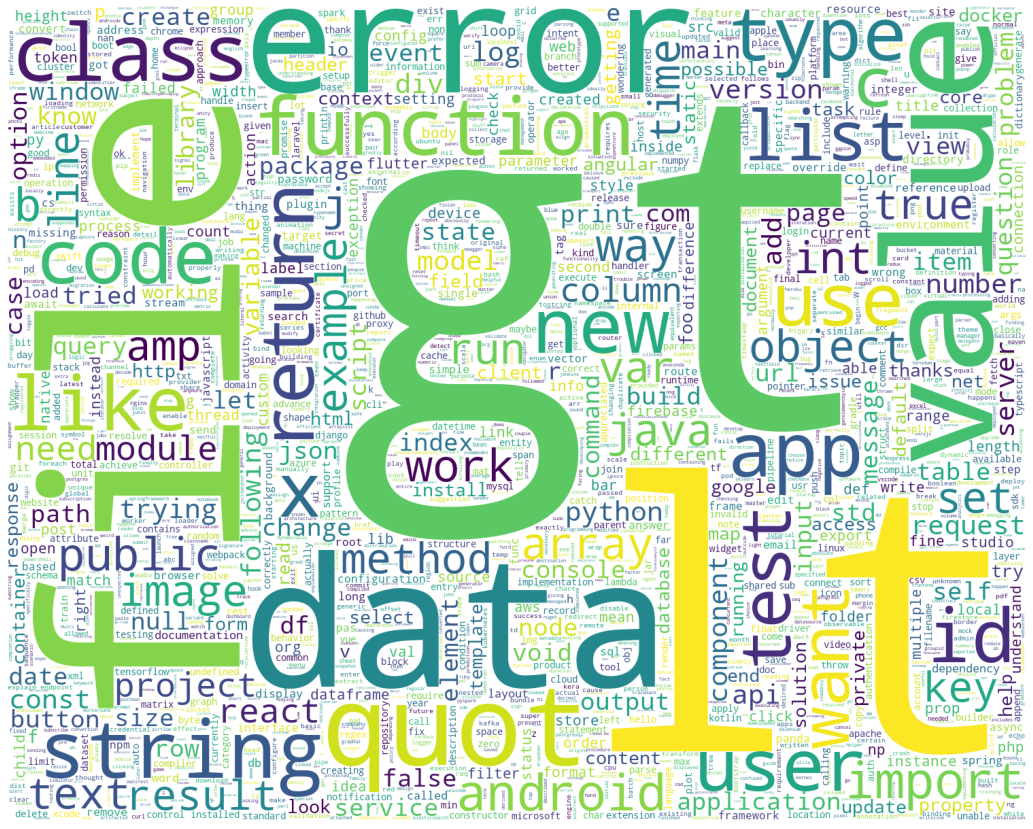

In [93]:
# all below in a single cell
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('recipes_wordcloud.png')

In [96]:
X_tfidf = pd.DataFrame(X_tfidf)
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.160154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042762,0.0,0.0,0.0,0.0,0.056064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
questions_value = vectorizer.vocabulary_
questions_value_df = pd.DataFrame(questions_value.items(), columns=['word', 'value'])
questions_value_df.head()


,word,value
0,unity,1868
1,developer,476
2,able,4
3,generic,734
4,type,1845


In [98]:
word_list = questions_value_df['word'].to_list()
X_tfidf.columns = word_list
X_tfidf.head()

,unity,developer,able,generic,type,parameter,derived,object,looking,answer,question,come,tell,following,difference,constraint,explicitly,state,method,public,static,lt,gt,original,position,rotation,happen,angular,component,class,dom,element,believe,service,pas,root,node,e,g,foo,...,resolved,intermediate,gender,cipher,gl,polygon,acc,ch,airflow,dag,nio,rect,bot,myproject,openssl,venv,cxx,stroke,sf,holder,artifact,patch,fabric,dimen,cart,upper,locale,st,vertex,mpl,dbo,gm,celery,ca,hr,cran,defaultbuildoperationexecutor,grpc,xsd,gyp
0,0.0,0.0,0.0,0.0,0.160154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042762,0.0,0.0,0.0,0.0,0.056064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
temp = df_sample[['Title_Body']]
X_tfidf = pd.concat([temp, X_tfidf], axis=1 )
X_tfidf.head()

,Title_Body,unity,developer,able,generic,type,parameter,derived,object,looking,answer,question,come,tell,following,difference,constraint,explicitly,state,method,public,static,lt,gt,original,position,rotation,happen,angular,component,class,dom,element,believe,service,pas,root,node,e,g,...,resolved,intermediate,gender,cipher,gl,polygon,acc,ch,airflow,dag,nio,rect,bot,myproject,openssl,venv,cxx,stroke,sf,holder,artifact,patch,fabric,dimen,cart,upper,locale,st,vertex,mpl,dbo,gm,celery,ca,hr,cran,defaultbuildoperationexecutor,grpc,xsd,gyp
0,unity developers able constrain generic type p...,0.0,0.0,0.0,0.0,0.160154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,angular component class dom element believe an...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sharepoint security inheritance underlying imp...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,distributed environment use multithreding work...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042762,0.0,0.0,0.0,0.0,0.056064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,karma test runner error error thrown afterall ...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
ohe_enc = OneHotCategoricalEncoder(
    top_categories=2000,
    variables=['Tag_st'],
    drop_last=False)
df_tags_num = ohe_enc.fit_transform(df_sample)
df_tags_num = df_tags_num.drop(['Title_Body',	'Title_Body_Tokens',	'Tags'], axis=1)
df_tags_num.head()

,Tag_st_python pandas,Tag_st_javascript,Tag_st_python,Tag_st_c++,Tag_st_r,Tag_st_python pandas dataframe,Tag_st_javascript reactjs,Tag_st_python python-3.x,Tag_st_java,Tag_st_dart flutter,Tag_st_angular,Tag_st_html css,Tag_st_flutter,Tag_st_typescript,Tag_st_r ggplot2,Tag_st_c#,Tag_st_android,Tag_st_reactjs,Tag_st_git,Tag_st_php laravel,Tag_st_haskell,Tag_st_react-native,Tag_st_javascript jquery,Tag_st_javascript html,Tag_st_python numpy,Tag_st_angular typescript,Tag_st_javascript html css,Tag_st_flutter dart,Tag_st_sql sql-server,Tag_st_ios swift,Tag_st_rust,Tag_st_docker,Tag_st_kotlin,Tag_st_visual-studio-code,Tag_st_javascript node.js,Tag_st_julia,Tag_st_python matplotlib,Tag_st_c++ c++11,Tag_st_raku,Tag_st_r dplyr,...,Tag_st_c++ types,Tag_st_amazon-web-services aws-lambda aws-api-gateway,Tag_st_android kotlin dagger-2,Tag_st_java swing jframe jpanel jbutton,Tag_st_javascript push-notification,Tag_st_javascript firebase firebase-authentication,Tag_st_mysql mysql-workbench,Tag_st_javascript destructuring,Tag_st_r ggplot2 density-plot,Tag_st_c# powershell,Tag_st_python-2.7,Tag_st_ios xcode swiftui,Tag_st_python numpy random random-seed,Tag_st_ios app-store,Tag_st_python-3.x python-imaging-library,Tag_st_c# entity-framework-core ef-core-2.2,Tag_st_asp.net crystal-reports,Tag_st_c++ c++11 stl,Tag_st_python pdf reportlab,Tag_st_html angular,Tag_st_java tomcat,Tag_st_gtk3 vala,Tag_st_keycloak,Tag_st_node.js sass gulp gulp-sass,Tag_st_mysql laravel eloquent,Tag_st_python csv,Tag_st_c# asp.net-mvc entity-framework,Tag_st_visual-studio-code vscode-extensions vscode-tasks,Tag_st_c# sql sql-server linq,Tag_st_docker docker-compose dockerfile,Tag_st_c++ templates inheritance,Tag_st_c++ templates gcc,Tag_st_python rounding,Tag_st_r dplyr tidyeval,Tag_st_android kotlin android-jetpack android-jetpack-navigation,Tag_st_java gradle build,Tag_st_reactjs react-bootstrap formik,Tag_st_java ssl,Tag_st_javascript jquery datatable,Tag_st_angular primeng primeng-turbotable
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
X_tfidf.to_csv('X_tfidf.csv')
df_tags_num.to_csv('y_onehot.csv')